<a href="https://colab.research.google.com/github/Swayamjexe/AgriPrice_Insights/blob/main/AgriPriceInsightsMLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [109]:
main_data = pd.read_csv('merged_market_weather_data.csv')

main_data.head()

,Sl no.,district,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),date,temperature_min,temperature_max,humidity,rain,pressure,cloud_cover,wind_speed,wind_direction
0,18,Amreli,Amreli,Wheat,Lokwan,FAQ,2060.0,2920,2830.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
1,50,Amreli,Amreli,Wheat,Rajasthan Tukdi,FAQ,2270.0,3070,2795.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
2,77,Amreli,Bagasara,Wheat,Lokwan Gujrat,FAQ,2305.0,2715,2510.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
3,470,Amreli,Dhari,Wheat,Lokwan Gujrat,FAQ,2615.0,2615,2615.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
4,1502,Amreli,Rajula,Wheat,PISSI,FAQ,2350.0,2735,2543.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368


In [110]:
main_data.columns = [
    'sl_no', 'district', 'market_name', 'commodity', 'variety', 'grade',
    'min_price_rs_quintal', 'max_price_rs_quintal', 'modal_price_rs_quintal',
    'date', 'temperature_min', 'temperature_max', 'humidity_percent', 'rain_mm',
    'pressure_hpa', 'cloud_cover_percent', 'wind_speed_kmph', 'wind_direction_degrees'
]

In [111]:
main_data.drop(columns=['sl_no'], inplace=True)  # Drop Serial number column
final_data = main_data.copy()

In [73]:
main_data.describe()

,min_price_rs_quintal,max_price_rs_quintal,modal_price_rs_quintal,temperature_min,temperature_max,humidity_percent,rain_mm,pressure_hpa,cloud_cover_percent,wind_speed_kmph,wind_direction_degrees
count,31003.000000,31003.000000,31003.000000,31003.000000,31003.000000,31003.000000,31003.000000,31003.000000,31003.000000,31003.000000,31003.000000
mean,2971.192885,3442.666065,3265.608881,26.234551,32.604844,74.733540,8.844394,1000.808818,81.967764,3.870361,189.690866
std,1906.877078,1941.510840,1905.298741,2.637864,4.662013,14.116310,15.837055,4.549584,20.634525,1.542247,71.061321
min,45.000000,0.000000,175.000000,19.410000,21.280000,34.500000,0.000000,991.375000,2.083333,0.921250,15.263158
25%,2220.000000,2500.000000,2400.000000,24.100000,28.870000,64.507675,0.000000,997.625000,70.916667,2.716458,119.416667
50%,2550.000000,3000.000000,2800.000000,26.000000,32.480000,78.000000,1.420000,1000.000000,90.500000,3.623750,201.666667
75%,3600.000000,4200.000000,4000.000000,27.870000,36.260000,86.208333,11.320000,1003.458333,99.041667,4.807917,252.604167
max,60000.000000,60080.000000,60040.000000,34.350000,45.350000,99.500000,179.170000,1012.958333,100.000000,10.446250,340.000000


In [74]:
main_data['date'] = pd.to_datetime(main_data['date'])

main_data['month'] = main_data['date'].dt.month
main_data['day_of_week'] = main_data['date'].dt.dayofweek

In [75]:
# One-Hot Encoding Categorical Features
main_data = pd.get_dummies(main_data, columns=['district', 'market_name', 'commodity', 'variety', 'grade'], drop_first=True)

In [76]:
# Feature Scaling: Normalize numerical features
scaler = StandardScaler()
numerical_features = [
    'temperature_min', 'temperature_max', 'humidity_percent', 'rain_mm',
    'pressure_hpa', 'cloud_cover_percent', 'wind_speed_kmph', 'wind_direction_degrees'
]
main_data[numerical_features] = scaler.fit_transform(main_data[numerical_features])

                        min_price_rs_quintal  max_price_rs_quintal  \
min_price_rs_quintal                1.000000              0.941679   
max_price_rs_quintal                0.941679              1.000000   
modal_price_rs_quintal              0.968971              0.987007   
temperature_min                    -0.079756             -0.139610   
temperature_max                    -0.121592             -0.178710   
humidity_percent                    0.112117              0.164452   
rain_mm                             0.020117              0.019269   
pressure_hpa                        0.232063              0.263777   
cloud_cover_percent                 0.061575              0.068075   
wind_speed_kmph                    -0.014714              0.037237   
wind_direction_degrees              0.133237              0.190230   
month                              -0.064023             -0.072765   
day_of_week                        -0.002160             -0.010252   

                   

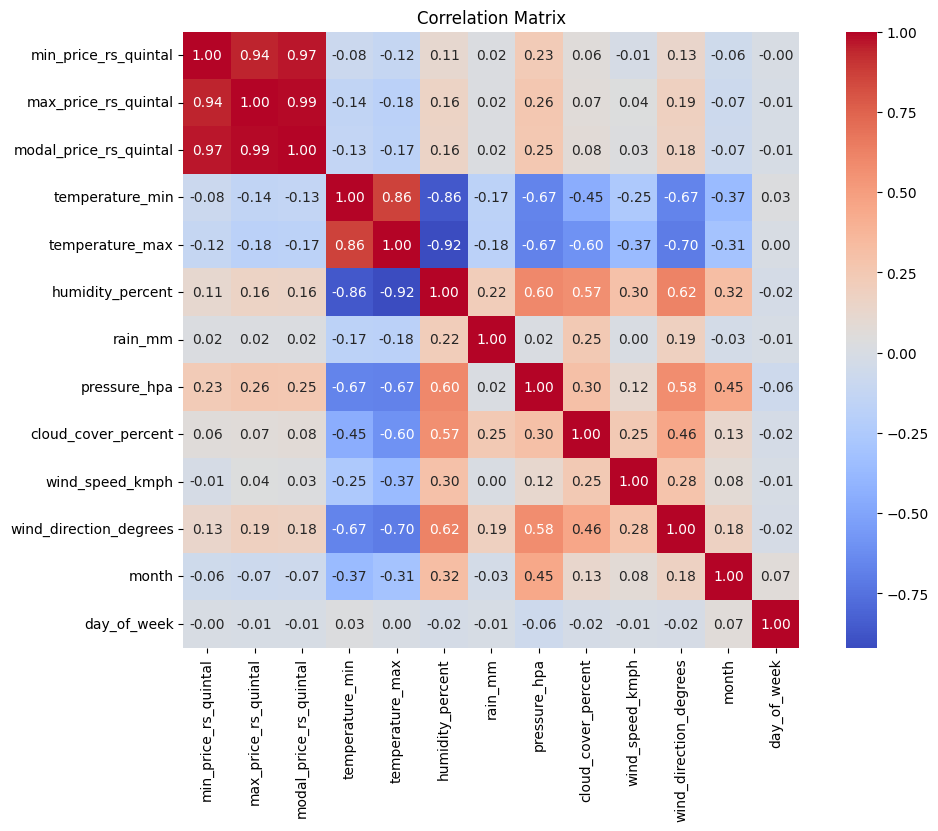

In [77]:
numeric_cols = [
    'min_price_rs_quintal', 'max_price_rs_quintal', 'modal_price_rs_quintal', 'temperature_min', 'temperature_max',
    'humidity_percent', 'rain_mm', 'pressure_hpa', 'cloud_cover_percent', 'wind_speed_kmph',
    'wind_direction_degrees', 'month', 'day_of_week'
]

# Calculate correlation matrix
correlation_matrix = main_data[numeric_cols].corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [78]:
# Drop the specified columns
columns_to_drop = ['day_of_week', 'wind_speed_kmph', 'month']
main_data.drop(columns=columns_to_drop, inplace=True)

In [79]:
# Define Predictor and Target Variables
X = main_data.drop(columns=['min_price_rs_quintal', 'max_price_rs_quintal', 'modal_price_rs_quintal', 'date'])
y = main_data[['modal_price_rs_quintal']]

In [80]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
X_train.head()

,temperature_min,temperature_max,humidity_percent,rain_mm,pressure_hpa,cloud_cover_percent,wind_direction_degrees,district_Ahmedabad,district_Akola,district_Alappuzha,...,variety_Soybean-Organic,variety_Sujata,variety_Tomato,variety_Wheat,variety_Wheat Mix,variety_Wheat-Organic,variety_White,variety_White (SAFED),variety_Without Ginned Cotton,variety_Yellow
17161,0.949818,1.019996,-0.946335,-0.558471,-1.688933,-0.949529,-1.245178,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6157,0.597254,0.503043,-0.527191,0.631795,-0.617389,-0.182194,-1.292672,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2030,-0.081336,-0.554457,0.691868,0.389953,-0.058721,-0.034785,0.074713,True,False,False,...,False,False,False,False,False,False,False,False,False,False
26279,-0.039635,-1.017784,0.709578,0.130431,1.608125,0.873901,1.134261,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16974,1.298590,1.069331,-1.099669,-0.558471,-1.566016,0.029620,-1.105902,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [81]:
!pip install lightgbm

In [83]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure the feature names are valid by replacing special characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)

# Prepare the datasets for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model with early stopping using the callback
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=10)
    ]
)

# Predict on test data
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"LightGBM - MAE: {mae}")
print(f"LightGBM - MSE: {mse}")
print(f"LightGBM - R^2: {r2}")


Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 1272.27	valid_1's rmse: 1587.87
[20]	training's rmse: 991.817	valid_1's rmse: 1285.74
[30]	training's rmse: 848.754	valid_1's rmse: 1130.01
[40]	training's rmse: 771.622	valid_1's rmse: 1038.66
[50]	training's rmse: 724.519	valid_1's rmse: 982.837
[60]	training's rmse: 696.136	valid_1's rmse: 951.71
[70]	training's rmse: 675.05	valid_1's rmse: 930.006
[80]	training's rmse: 658.109	valid_1's rmse: 909.756
[90]	training's rmse: 637.333	valid_1's rmse: 889.775
[100]	training's rmse: 627.195	valid_1's rmse: 875.974
[110]	training's rmse: 613.28	valid_1's rmse: 856.498
[120]	training's rmse: 606.78	valid_1's rmse: 853.98
[130]	training's rmse: 586.937	valid_1's rmse: 832.114
[140]	training's rmse: 577.17	valid_1's rmse: 820.912
[150]	training's rmse: 570.79	valid_1's rmse: 814.613
[160]	training's rmse: 562.407	valid_1's rmse: 803.701
[170]	training's rmse: 556.327	valid_1's rmse: 801.347
[180]	training's rm

In [84]:
# Define the LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', boosting_type='gbdt')

# Define the parameter space for RandomizedSearchCV
param_dist = {
    'num_leaves': np.arange(20, 150, 10),  # Number of leaves in trees
    'learning_rate': np.logspace(-3, 0, 10),  # Learning rate between 0.001 and 1
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting rounds (trees)
    'min_child_samples': np.arange(5, 50, 5),  # Minimum data per leaf
    'subsample': np.linspace(0.6, 1.0, 5),  # Fraction of samples used in training each tree
    'colsample_bytree': np.linspace(0.6, 1.0, 5)  # Fraction of features used per tree
}

# Setup RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of iterations to limit computational expense
    scoring='neg_mean_squared_error',  # Optimize for MSE
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Run RandomizedSearchCV
random_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", -random_search.best_score_)

# Predict using the best estimator
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized LightGBM - MAE: {mae}")
print(f"Optimized LightGBM - MSE: {mse}")
print(f"Optimized LightGBM - R^2: {r2}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 24802, number of used features: 769
[LightGBM] [Info] Start training from score 3263.765003
Best parameters found:  {'subsample': 0.8, 'num_leaves': 110, 'n_estimators': 250, 'min_child_samples': 5, 'learning_rate': 0.046415888336127774, 'colsample_bytree': 1.0}
Best cross-validation score:  273378.2330518752
Optimized LightGBM - MAE: 228.42110503624642
Optimized LightGBM - MSE: 439707.0615255091
Optimized LightGBM - R^2: 0.9074286220951914


In [99]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression - MAE:", mae_rf)
print("Random Forest Regression - MSE:", mse_rf)
print("Random Forest Regression - R^2:", r2_rf)

<ipython-input-99-c98d6d6b6404>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random Forest Regression - MAE: 207.2130292210934
Random Forest Regression - MSE: 394238.22287225776
Random Forest Regression - R^2: 0.9170011612108014


In [112]:
final_data.head()

,district,market_name,commodity,variety,grade,min_price_rs_quintal,max_price_rs_quintal,modal_price_rs_quintal,date,temperature_min,temperature_max,humidity_percent,rain_mm,pressure_hpa,cloud_cover_percent,wind_speed_kmph,wind_direction_degrees
0,Amreli,Amreli,Wheat,Lokwan,FAQ,2060.0,2920,2830.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
1,Amreli,Amreli,Wheat,Rajasthan Tukdi,FAQ,2270.0,3070,2795.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
2,Amreli,Bagasara,Wheat,Lokwan Gujrat,FAQ,2305.0,2715,2510.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
3,Amreli,Dhari,Wheat,Lokwan Gujrat,FAQ,2615.0,2615,2615.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368
4,Amreli,Rajula,Wheat,PISSI,FAQ,2350.0,2735,2543.0,2024-08-09,25.84,32.46,71.526316,0.0,1006.789474,95.421053,6.366842,253.947368


In [115]:
#
X = final_data.drop(columns=['modal_price_rs_quintal', 'date', 'min_price_rs_quintal', 'max_price_rs_quintal', 'wind_speed_kmph'])  # Replace 'Price' with the actual target column name
y = final_data['modal_price_rs_quintal']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()


# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
    ]
)

#Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf_model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Save the entire pipeline as a pickle file
joblib.dump(pipeline, 'final_rf_pipeline.pkl')

print("Pipeline has been saved as 'final_rf_pipeline.pkl'")

Pipeline has been saved as 'final_rf_pipeline.pkl'


In [116]:
X_train.head()

,district,market_name,commodity,variety,grade,temperature_min,temperature_max,humidity_percent,rain_mm,pressure_hpa,cloud_cover_percent,wind_direction_degrees
17161,Sitapur,Viswan,Onion,Red,FAQ,28.74,37.36,61.375000,0.00,993.125000,62.375000,101.208333
6157,Vidisha,Vidisha,Wheat,Sharbati,FAQ,27.81,34.95,67.291667,18.85,998.000000,78.208333,97.833333
2030,Ahmedabad,Ahmedabad,Tomato,Other,FAQ,26.02,30.02,84.500000,15.02,1000.541667,81.250000,195.000000
26279,Kannur,Kannur,Onion,Other,FAQ,26.13,27.86,84.750000,10.91,1008.125000,100.000000,270.291667
16974,Sitapur,Sitapur,Tomato,Hybrid,FAQ,29.66,37.59,59.210526,0.00,993.684211,82.578947,111.105263


In [118]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.7 MB/s eta 0:00:00


In [120]:
import joblib
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import pandas as pd

# Load the fitted pipeline
pipeline = joblib.load('final_rf_pipeline.pkl')

# Initialize FastAPI
app = FastAPI()

# Define input data schema
class InputData(BaseModel):
    district: str
    market_name: str
    commodity: str
    variety: str
    grade: str
    temperature_min: float
    temperature_max: float
    humidity_percent: float
    rain_mm: float
    pressure_hpa: float
    cloud_cover_percent: float
    wind_direction_degrees: float

# Prediction endpoint
@app.post("/predict")
async def predict(data: InputData):
    try:
        # Convert input data to DataFrame
        input_df = pd.DataFrame([data.dict()])

        # Rename columns to match the model's expected input
        input_df.columns = [
            'district', 'market_name', 'commodity', 'variety', 'grade',
            'temperature_min', 'temperature_max', 'humidity_percent', 'rain_mm',
            'pressure_hpa', 'cloud_cover_percent', 'wind_direction_degrees']

        # Make prediction
        prediction = pipeline.predict(input_df)

        return {"prediction": prediction[0]}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


In [121]:
!pip install pyngrok

In [122]:
!ngrok authtoken 22y5D5O6lpIT6ogZ4t1V0AB3oWP_2PcfgPrfveSbZ33aSaadx

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [123]:
from pyngrok import ngrok
import threading

# Start the FastAPI app with Uvicorn
import uvicorn

public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

# Define a function to run the app
def run_app():
    uvicorn.run(app, host="0.0.0.0", port=5000)

# Run the server in a separate thread
thread = threading.Thread(target=run_app)
thread.start()

Public URL: NgrokTunnel: "https://93ef-34-82-224-18.ngrok-free.app" -> "http://localhost:5000"


INFO:     Started server process [612]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:5000 (Press CTRL+C to quit)


In [125]:
import requests

# Replace the URL with your ngrok public URL
url = 'https://93ef-34-82-224-18.ngrok-free.app/predict'

# Example input data
data = {
    "district": "Faridkot",
    "market_name": "Kotkapura",
    "commodity": "Potato",
    "variety": "Potato",
    "grade": "FAQ",
    "temperature_min": 26.11,
    "temperature_max": 29.11,
    "humidity_percent": 87.54166666666667,
    "rain_mm": 62.92999999999999,
    "pressure_hpa": 998.25,
    "cloud_cover_percent": 93.70833333333331,
    "wind_direction_degrees": 165.16666666666666
}

response = requests.post(url, json=data)
print(response.json())

INFO:     34.82.224.18:0 - "POST /predict HTTP/1.1" 200 OK
{'prediction': 2102.98}


In [126]:
pip freeze > requirements.txt